## Huggingface version (Torch)

In [1]:

from transformers import AutoModelForCausalLM
import torch
import numpy as np

model_path = "./model_files/" # local
model_path_hf = "SequentialLearning/SuperLinear"
model = AutoModelForCausalLM.from_pretrained(model_path_hf,trust_remote_code=True, force_download=True) 

/home/lirannoc/.conda/envs/timemoe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lirannoc/.conda/envs/timemoe/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/lirannoc/.conda/envs/timemoe/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creating complementary expert 0
Creating complementary expert 1
Creating complementary expert 2
Creating complementary expert 3
Creating complementary expert 4
Creating complementary expert 5
Creating complementary expert 6
Creating complementary expert 7
Creating complementary expert 8
Creating complementary expert 9
Creating complementary expert 10
Creating complementary expert 11
Experts: dict_keys(['mean', 'naive', '1/4', '1/6', '1/7', '1/8', '1/12', '1/14', '1/16', '1/21', '1/24', '1/28', '1/30', '1/32', '1/36', '1/42', '1/48', '1/52', '1/56', '1/60', '1/72', '1/84', '1/90', '1/96', '1/120', '1/144', '1/168', '1/180', '1/224', '1/252', '1/288', '1/336', '1/365', '1/504', '1/672', '1/1008', '1/1440', '1/2016', '1/3600', 'comp_0', 'comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5', 'comp_6', 'comp_7', 'comp_8', 'comp_9', 'comp_10', 'comp_11'])


In [2]:
seq_len = 512
pred_len = 96

freq = 1/24
amp = 1
ph = 0

t = torch.arange(0, seq_len+ pred_len)
s = amp * torch.sin(2 * np.pi * freq * t + ph)
x = s[:seq_len].unsqueeze(0)  # Add batch dim
y = s[seq_len:].unsqueeze(0)  # Add batch dim

with torch.no_grad():
    # takes shapes (B, V, L) or (B, L)
    output = model(x, pred_len=pred_len, get_prob=True)
    preds = output.logits # Predicted values
    probs = output.attentions  # Expert probabilities stored here
expert_names = model.backbone.experts.keys()

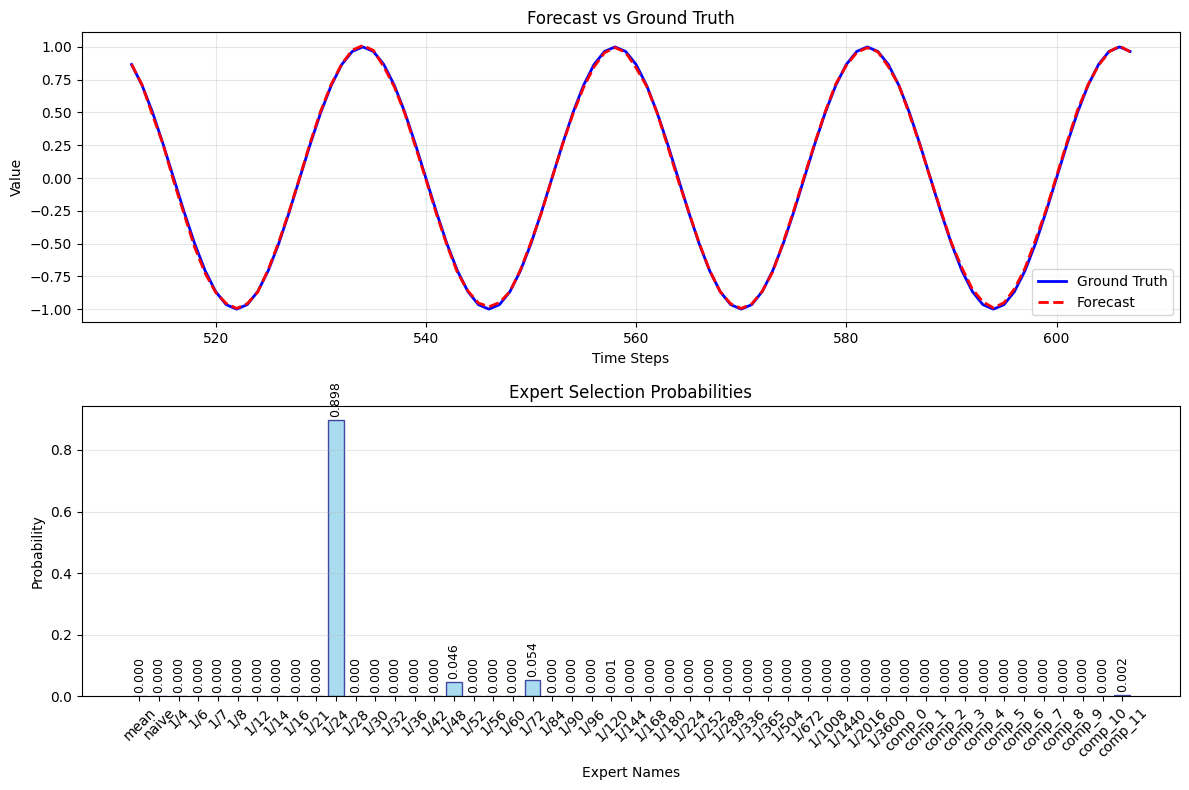

In [3]:
import matplotlib.pyplot as plt

# Convert to numpy for plotting
preds_np = preds.detach().cpu().numpy().squeeze()
y_np = y.detach().cpu().numpy().squeeze()
probs_np = probs.detach().cpu().numpy().squeeze()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Forecast vs Ground Truth
time_pred = torch.arange(seq_len, seq_len + pred_len)
ax1.plot(time_pred, y_np, label='Ground Truth', linewidth=2, color='blue')
ax1.plot(time_pred, preds_np, label='Forecast', linewidth=2, color='red', linestyle='--')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Value')
ax1.set_title('Forecast vs Ground Truth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Expert Probabilities
expert_names_list = list(expert_names)
bars = ax2.bar(expert_names_list, probs_np, alpha=0.7, color='skyblue', edgecolor='navy')
ax2.set_xlabel('Expert Names')
ax2.set_ylabel('Probability')
ax2.set_title('Expert Selection Probabilities')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, prob_val in zip(bars, probs_np):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prob_val:.3f}', ha='center', va='bottom', fontsize=9, color='black', rotation=90)

plt.tight_layout()
plt.show()